Fruits and Vegetables Classification


In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from PIL import Image



/Users/karlap/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
ORIG_DATASET_DIR = "/Users/karlap/Documents/Universidad/dataset"
TARGET_DIR = "/Users/karlap/Documents/Universidad/dataset_dividido"

train_split = 0.70
val_split = 0.10
test_split = 0.20

random.seed(42)

for folder_name in os.listdir(ORIG_DATASET_DIR):
    folder_path = os.path.join(ORIG_DATASET_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    if '_' not in folder_name:
        continue

    fruit, condition = folder_name.split('_', 1)  
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not images:
        continue
    
    random.shuffle(images)
    total = len(images)
    train_end = int(train_split * total)
    val_end = train_end + int(val_split * total)


    subsets = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for subset, files in subsets.items():
        dest_dir = os.path.join(TARGET_DIR, subset, folder_name)
        os.makedirs(dest_dir, exist_ok=True)
        for file in files:
            src_file = os.path.join(folder_path, file)
            dest_file = os.path.join(dest_dir, file)
            try:
                with Image.open(src_file) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    img.save(dest_file)
            except Exception as e:
                print(f"Error procesando {src_file}: {e}")


/Users/karlap/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
train_dir = os.path.join(TARGET_DIR, "train")
val_dir = os.path.join(TARGET_DIR, "val")
test_dir = os.path.join(TARGET_DIR, "test")

train_datagen = ImageDataGenerator (
    rescale = 1./255,
    rotation_range = 20, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (224, 224),
	batch_size = 32,
	class_mode ='categorical',
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 20484 images belonging to 28 classes.
Found 2917 images belonging to 28 classes.
Found 5876 images belonging to 28 classes.


Red neuronal convolutiva 


In [12]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1028, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(test_generator.num_classes, activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    metrics=['accuracy'])

model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1028)           │     4,211,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,474,336 (146.77 MB)

 Trainable params: 23,759,648 (90.64 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
history = model.fit(
    train_generator,
    epochs = 5,
    validation_data=val_generator,
)

Epoch 1/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 2573s 4s/step - accuracy: 0.1337 - loss: 2.8906 - val_accuracy: 0.4028 - val_loss: 1.8021
Epoch 2/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 2424s 4s/step - accuracy: 0.4012 - loss: 1.9155 - val_accuracy: 0.5704 - val_loss: 1.2907
Epoch 3/5
641/641 ━━━━━━━━━━━━━━━━━━━━ 2670s 4s/step - accuracy: 0.5206 - loss: 1.4911 - val_accuracy: 0.6315 - val_loss: 1.0835
Epoch 4/5
198/641 ━━━━━━━━━━━━━━━━━━━━ 23:59 3s/step - accuracy: 0.6020 - loss: 1.2582

KeyboardInterrupt: 

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print('\ntest acc: \n', test_acc)
print('\ntest loss: \n', test_loss)

184/184 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.6778 - loss: 0.9546

test acc: 
 0.6790333390235901

test loss: 
 0.95984947681427


Evaluación del Modelo

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Obtener todas las imágenes y etiquetas del generador de prueba
test_images = []
test_labels = []

for i in range(len(test_generator)):
    imgs, labels = test_generator[i]
    test_images.extend(imgs)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_labels = np.argmax(test_labels, axis=1)

# Predicciones del modelo
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

184/184 ━━━━━━━━━━━━━━━━━━━━ 589s 3s/step


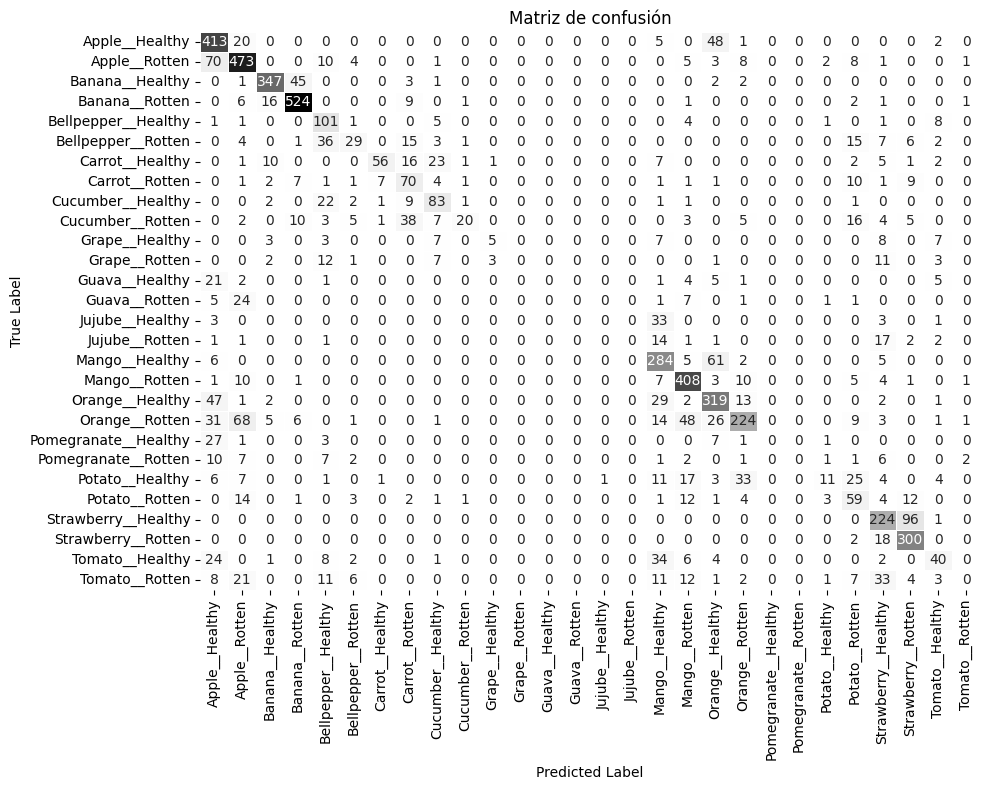

In [20]:
import seaborn as sns
# Calcular la matriz de confusión
mat = confusion_matrix(test_labels, predicted_classes)

# Obtener nombres de clases
class_names = [None] * len(test_generator.class_indices)
for name, index in test_generator.class_indices.items():
    class_names[index] = name

# Mostrar matriz de confusión clara y legible
plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names, linewidths=0.7, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

In [23]:
# Calcular métricas
accuracy = accuracy_score(test_labels, predicted_classes)
recall = recall_score(test_labels, predicted_classes, average='macro')
f1 = f1_score(test_labels, predicted_classes, average='macro')

# Métricas
print("\n--- MÉTRICAS  ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



--- MÉTRICAS  ---
Accuracy:  0.6790
Recall:    0.4303
F1 Score:  0.4140


Guardar el modelo

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
%cd "/Users/karlap/Documents/Universidad/SavingModel"
!mkdir "save_model"
model.save("save_model/mi_modelo.keras")

/Users/karlap/Documents/Universidad/SavingModel
mkdir: save_model: File exists


/Users/karlap/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
